# Plotting a resistivity model from ModEM on a basemap

In this example we will plot a resistivity model on a basemap. This example is a bit more complex than previous examples, as, unlike the previous examples, the basemap plotting functionality is not contained within MTPy. This has the benefit that it makes it easier to customise the plot. But it may mean it takes a bit longer to become familiar with the functionality.

The first step is to import the required modules needed. We have three MTPy imports - Model, Data and gis_tools. Then there is some standard matplotlib functionality and importantly the basemap module which creates coastlines and the nice borders.

In [1]:
from mtpy.modeling.modem import Model, Data
from mtpy.utils import gis_tools

import matplotlib.pyplot as plt
from matplotlib import colors

from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon
from descartes import PolygonPatch
import numpy as np

If you want to write a vtk file for 3d viewing, you need download and install evtk from https://bitbucket.org/pauloh/pyevtk
Note: if you are using Windows you should build evtk first witheither MinGW or cygwin using the command: 
    python setup.py build -compiler=mingw32  or 
    python setup.py build -compiler=cygwin
If you want to write a vtk file for 3d viewing, you need to install pyevtk
Note: if you are using Windows you should build evtk first witheither MinGW or cygwin using the command: 
    python setup.py build -compiler=mingw32  or 
    python setup.py build -compiler=cygwin
If you want to write a vtk file for 3d viewing, you need download and install evtk from https://bitbucket.org/pauloh/pyevtk
If you want to write a vtk file for 3d viewing, you need to pip install PyEVTK: https://bitbucket.org/pauloh/pyevtk
Note: if you are using Windows you should build evtk first witheither MinGW or cygwin using the command: 
    python setup.py build -compiler=mingw32  or 
    python

If you want to write a vtk file for 3d viewing, you need download and install evtk from https://bitbucket.org/pauloh/pyevtk


The next step is to create a function that will draw an inset map showing the survey boundaries on Australia.

In [2]:
# function to draw a bounding box
def drawBBox( minLon, minLat, maxLon, maxLat, bm, **kwargs):
    bblons = np.array([minLon, maxLon, maxLon, minLon, minLon])
    bblats = np.array([minLat, minLat, maxLat, maxLat, minLat])
    
    x, y = bm( bblons, bblats )
    xy = zip(x,y)
    poly = Polygon(xy)
    bm.ax.add_patch(PolygonPatch(poly, **kwargs))

We now need to define our file paths for the response and data files

In [3]:
# define paths
data_fn = r'C:/mtpywin/mtpy/examples/model_files/ModEM/ModEM_Data.dat'
model_fn = r'C:/mtpywin/mtpy/examples/model_files/ModEM/Modular_MPI_NLCG_004.rho'

# define extents
minLat = -30.4
maxLat = -30.
minLon = 133.45
maxLon = 134

# position of inset axes (bottom,left,width,height)
inset_ax_position = [0.6,0.2,0.3,0.2]

We can now create the plot!

      -15500.000      -21500.000         -67.000

    0.000

2018-10-10T12:14:44 - Data - INFO - Set rotation angle to 0.0 deg clockwise from N


C:\mtpywin\mtpy\mtpy\utils\calculator.py:322: RuntimeWarning: invalid value encountered in double_scalars
  z_rel_err = error/z_amp


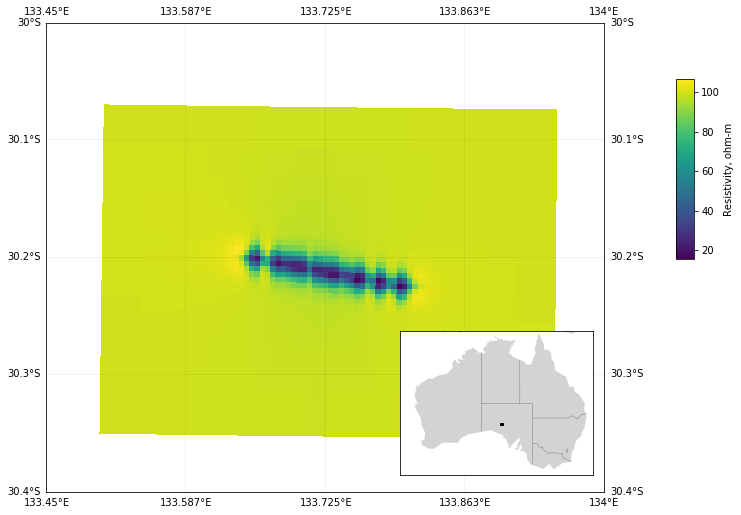

In [4]:
# read in ModEM data to phase tensor object
mObj = Model()
mObj.read_model_file(model_fn = model_fn)

dObj = Data()
dObj.read_data_file(data_fn = data_fn)

# get easting and northing of model grid
east = mObj.grid_east + dObj.center_point['east']
north = mObj.grid_north + dObj.center_point['north']
gcx,gcy = [[np.mean(arr[i:i+2]) for i in range(len(arr)-1)] for arr in [east,north]]

# make a meshgrid, save the shape
east_grid,north_grid = np.meshgrid(east,north)
shape = east_grid.shape

# project to lat, lon
lonr,latr = gis_tools.epsg_project(east_grid,north_grid,28353,4326)

# define resistivity model and station locations
resvals = mObj.res_model.copy()
sloc = dObj.station_locations

# make a figure
fig, ax = plt.subplots(figsize=(10,10))

# make a basemap
m = Basemap(resolution='c', # c, l, i, h, f or None
            ax=ax,
            projection='merc',
            lat_0=-20.5, lon_0=138, # central lat/lon for projection
            llcrnrlon=minLon, llcrnrlat=minLat, urcrnrlon=maxLon, urcrnrlat=maxLat)

# draw lat-lon grids
m.drawparallels(np.linspace(minLat, maxLat, 5), labels=[1,1,0,0], linewidth=0.1)
m.drawmeridians(np.linspace(minLon, maxLon, 5), labels=[0,0,1,1], linewidth=0.1)
m.drawcoastlines()

# plot the resistivity model
mpldict={}
mpldict['cmap'] = 'jet_r'
mpldict['norm'] = colors.LogNorm()
mpldict['vmin'] = 2
mpldict['vmax'] = 5e3
x,y = m(lonr,latr)
mappable = m.pcolormesh(x,y,resvals[:,:,20])
xp,yp=m(sloc.lon,sloc.lat)
plt.plot(xp,yp,'k+')

# plot inset map ==================================================================
insetAx = fig.add_axes(inset_ax_position)
mInset = Basemap(resolution='c', # c, l, i, h, f or None
           ax=insetAx,
           projection='merc',
           lat_0=-20, lon_0=132,
            llcrnrlon=110, llcrnrlat=-40, urcrnrlon=155, urcrnrlat=-10)

mInset.fillcontinents(color='lightgray')
mInset.drawstates(color="grey")
drawBBox(minLon, minLat, maxLon, maxLat, mInset, fill='True', facecolor='k')

# make a colour bar
cbax = fig.add_axes([1.,0.5,0.025,.25])
cbar = plt.colorbar(mappable,ax=ax,cax=cbax)
cbar.set_label('Resistivity, ohm-m')
